In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from __future__ import print_function

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Embedding, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.regularizers import l2
from keras.utils.data_utils import get_file
import numpy as np
import numpy.random as nr
import random
import glob
import sys
import os
import re

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120)

Using TensorFlow backend.


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        self.model.reset_states()


def train_network(model, model_name, X_train, y_train, Xval=None, yval=None, loss="categorical_crossentropy",
                  metrics=None, opt='rmsprop', batch_size=60, nepochs=50000, patience=500, 
                  nr_seed=20170522, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=metrics)    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if tr_epochs <= 0:
        print('[INFO] Model already trained for {} epochs'.format(nepochs))
        return model, cb
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2
        
    if Xval is not None:
        val_data = (Xval, yval)
    else:
        val_data = None

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=batch_size, epochs=tr_epochs, verbose=vv, 
                      validation_data=val_data, callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb


def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


In [4]:
'''Example script showing how to use stateful RNNs to model long sequences efficiently.'''

# since we are using stateful rnn tsteps can be set to 1
tsteps = 1
batch_size = 25
epochs = 50

# number of elements ahead that are used to make the prediction
lahead = 1


def gen_cosine_amp(amp=100, period=1000, x0=0, xn=50000, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing

    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros(((xn - x0) * step, 1, 1))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(2 * np.pi * idx / period)
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
    return cos


print('Generating Data...')
cos = gen_cosine_amp()
print('Input shape:', cos.shape, cos.min(), cos.max())

expected_output = np.zeros((len(cos), 1))
for i in range(len(cos) - lahead):
    expected_output[i, 0] = np.mean(cos[i + 1:i + lahead + 1])

print('Output shape:', expected_output.shape)

Generating Data...
Input shape: (50000, 1, 1) -95.1345801792 100.0
Output shape: (50000, 1)


In [5]:
print('Creating Model...')
model = Sequential()
model.add(LSTM(50,
               input_shape=(tsteps, 1),
               batch_size=batch_size,
               return_sequences=True,
               stateful=True))
model.add(LSTM(50,
               return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.summary()

Creating Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (25, 1, 50)               10400     
_________________________________________________________________
lstm_2 (LSTM)                (25, 50)                  20200     
_________________________________________________________________
dense_1 (Dense)              (25, 1)                   51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


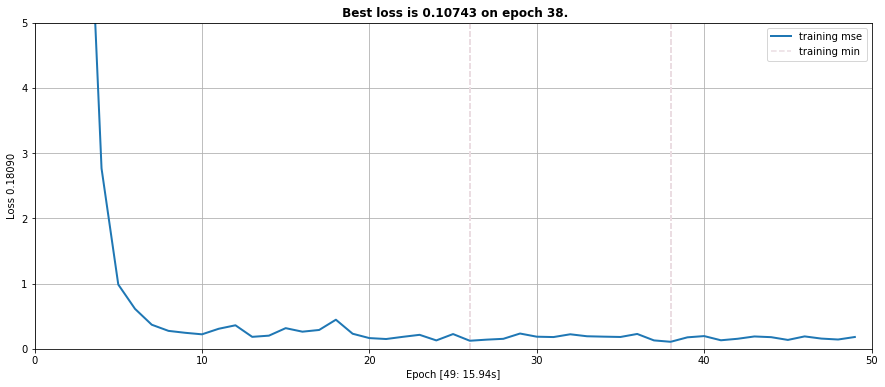

In [11]:
model_name = '../../models/lstm_stateful_cos_1'

fit_params = {
    'opt':        Adam(),
    'loss':       'mse',
    'batch_size': batch_size, 
    'nepochs':    epochs,
    'patience':   15,
    'ploss':      5.0,
    'reset':      False,
}

# Note that the last state for sample i in a batch will
# be used as initial state for sample i in the next batch.
# Thus we are simultaneously training on batch_size series with
# lower resolution than the original series contained in cos.
# Each of these series are offset by one step and can be
# extracted with cos[i::batch_size].
#
# Also note the use of model.reset_states() in the on_epoch_end
# method of the MyCb callback.

train_network(model, model_name, cos, expected_output, **fit_params);


Predicting
Plotting Results


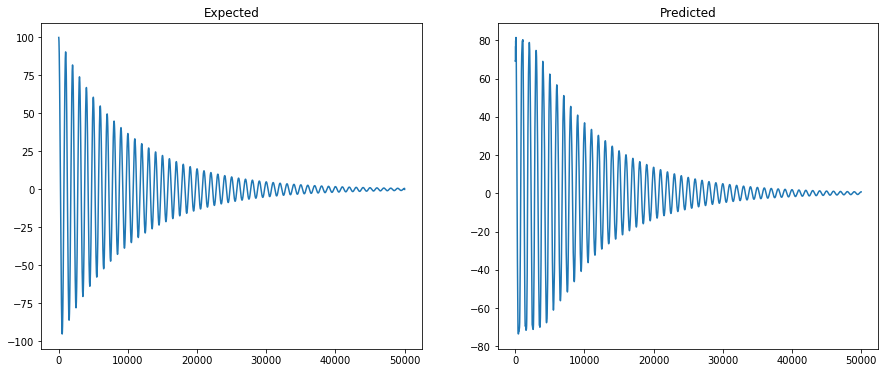

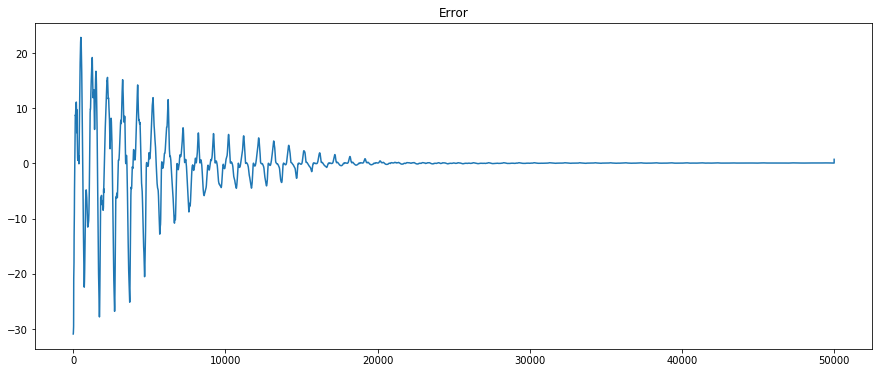

In [12]:
print('Predicting')
predicted_output = model.predict(cos, batch_size=batch_size)

print('Plotting Results')
fig = plot.figure(figsize=(15,6))
plot.subplot(1, 2, 1)
plot.plot(expected_output)
plot.title('Expected')
plot.subplot(1, 2, 2)
plot.plot(predicted_output)
plot.title('Predicted')

fig = plot.figure(figsize=(15,6))
plot.plot(predicted_output - expected_output)
plot.title('Error');
